# Training on SAE Sparse Features

Loss factor of 0.01, working with the 25 highest activating features per digit

Cosine instead of MSE for auxilary loss - it seemed to work quite well, and makes auxiliary loss easier to manage w/global loss.

In [1]:
import time
import pickle


EXPERIMENT_TYPE = "SAE"
RUN_ID = time.time()

## SAE Params

In [2]:
HIDDEN_SIZE = 256
L1_PENALTY = 0.01
N = 25

## Imports

In [3]:
import random
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [4]:
from graph_helpers import (plot_weights,
                    plot_activations,
                    plot_losses,
                    plot_saliency_map,
                    plot_sparse_vecs_by_image,
                    plot_top_act_images_by_feature,
                    feature_inversion
                )

In [5]:
import sys, os
from pathlib import Path

# assume cwd is project_root/data_loader
project_root = Path(os.getcwd()).parent  # go up one level to project_root
sys.path.insert(0, str(project_root))

from helpers import load_images, load_labels, visualize_image, get_edges, load_intermediate_labels

## Set Device to GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

## Load Data

In [ ]:
# train data
train_images = load_intermediate_labels("first_layer/train_images.pkl")
train_labels = load_intermediate_labels("first_layer/train_labels.pkl")

# val data
val_images = load_intermediate_labels("first_layer/val_images.pkl")
val_labels = load_intermediate_labels("first_layer/val_labels.pkl")

# test data
test_images = load_intermediate_labels("first_layer/test_images.pkl")
test_labels = load_intermediate_labels("first_layer/test_labels.pkl")

# intermediate labels
recon_max_sparse_act_one = load_intermediate_labels(f"first_layer/train_images_recon_max_sparse_top_{N}.pkl")
recon_max_sparse_act_one_ablated = load_intermediate_labels(f"first_layer/train_images_recon_max_sparse_ablated_top_{N}.pkl")

In [ ]:
type(recon_max_sparse_act_one[0])

In [ ]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

## Visualize an image

In [ ]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Architecture

### NN

Once again, two hidden layers. 16 nodes each. Same as 3blue1brown.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.hidden_one = nn.Linear(layer_size_by_pixels, 16)
        self.hidden_two = nn.Linear(16, 16)
        self.classification_layer = nn.Linear(16, 10)
        
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # first hidden layer
        hidden_one_out = self.hidden_one(x)
        hidden_one_act = self.activation_function(hidden_one_out)

        # second hidden layer
        hidden_two_out = self.hidden_two(hidden_one_act)
        hidden_two_act = self.activation_function(hidden_two_out)

        # classification layer
        classification_out = self.classification_layer(hidden_two_act)
        
        return classification_out, hidden_one_act, hidden_two_act

### SAE

In [ ]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_size=128):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        encoded = self.activation(self.encoder(x))
        reconstructed = self.decoder(encoded)
        return reconstructed, encoded
    
    def loss(self, x, reconstructed, encoded, l1_lambda=0.001):
        mse_loss = nn.MSELoss()(reconstructed, x)
        l1_loss = l1_lambda * torch.mean(torch.abs(encoded))
        return mse_loss + l1_loss

## Dataloader

In [ ]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, first_layer_acts=None):
        self.images = images
        self.labels = labels
        self.first_layer_acts = first_layer_acts

    def __len__(self):
        assert len(self.images) == len(self.labels)
        if self.first_layer_acts:
            assert(len(self.first_layer_acts) == len(self.images))
            
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx].copy()).float()
        label = torch.tensor(self.labels[idx].copy(), dtype=torch.long)

        if self.first_layer_acts:
            return (image, label, self.first_layer_acts[idx])
        else:
            return (image, label)

In [ ]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## Training Loop

In [ ]:
loss_factors = np.arange(0.01 + 0.001, 0.05 + 0.001, 0.001)
print(len(loss_factors))

In [ ]:
loss_data_dict = {}
for loss_factor in loss_factors:
    print("#" * 50)
    print(f"Loss factor: {loss_factor}\n\n")
    ######################################################################################################
    # MODELS INIT
    ######################################################################################################
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    model = NeuralNetwork().to(device)
    
    # loss functions
    classification_loss_fn = nn.CrossEntropyLoss()
    hidden_act_one_loss_fn = nn.CosineSimilarity()
    
    # optimizers
    optimizer = torch.optim.Adam(model.parameters())
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    sae_hidden_two = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
    optimizer_sae_hidden_two = torch.optim.Adam(sae_hidden_two.parameters())
    
    # for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
    sae_hidden_one = SparseAutoencoder(input_size=16, hidden_size=HIDDEN_SIZE).to(device)
    optimizer_sae_hidden_one = torch.optim.Adam(sae_hidden_one.parameters())
    
    ######################################################################################################
    # DATA INIT
    ######################################################################################################
    
    generator = torch.Generator().manual_seed(seed)
    
    NUM_WORKERS = 4
    if device.type.lower() == "cpu":
        NUM_WORKERS = 0
    
    # training data
    train_dataset = EdgeDataset(train_images, train_labels, recon_max_sparse_act_one)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=NUM_WORKERS, worker_init_fn=seed_worker, generator=generator)
    
    # validation data
    val_dataset = EdgeDataset(val_images, val_labels)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)  # larger batch size for faster validation
    
    # test data
    test_dataset = EdgeDataset(test_images, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=NUM_WORKERS)
    
    ######################################################################################################
    # TRAINING LOOP
    ######################################################################################################
    best_model = None
    best_sae_one = None
    best_sae_two = None
    num_epochs = 20
    
    best_val_acc = 0.0
    best_val_loss = float('inf')
    
    validation_losses = []
    training_losses = []
    SAE_hidden_one_losses = []
    SAE_hidden_two_losses = []
    
    # Initialize storage for training features and labels
    feature_activations_one_train = torch.zeros(HIDDEN_SIZE, len(train_loader.dataset))
    feature_activations_two_train = torch.zeros(HIDDEN_SIZE, len(train_loader.dataset))
    labels_train = torch.zeros(len(train_loader.dataset), dtype=torch.long)
    
    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()  # set the model to training mode - this is currently a no-op
        sae_hidden_two.train()
        sae_hidden_one.train()
        
        train_loss = 0.0
        total_sae_loss_hidden_two = 0.0
        total_sae_loss_hidden_one = 0.0
    
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
        for batch_idx, batch in enumerate(train_bar):
            # deconstruct batch items
            images, labels, acts_one = batch
            images, labels, acts_one = images.to(device), labels.to(device), acts_one.to(device)
            
            # forward pass
            classification_out, hidden_act_one, hidden_act_two = model(images)
    
            # Classification loss and backprop
            optimizer.zero_grad()
            
            sub_loss = (1 - hidden_act_one_loss_fn(hidden_act_one, acts_one)).mean()
            total_loss = classification_loss_fn(classification_out, labels) + loss_factor * (sub_loss)
            total_loss.backward()
            
            optimizer.step()
            train_loss += total_loss.item()
            train_bar.set_postfix(loss=total_loss.item())
    
            # to prevent backprop on both graphs:
            hidden_act_one_detached = hidden_act_one.detach()
            hidden_act_two_detached = hidden_act_two.detach()
    
            # SAE loss and backprop - hidden layer one
            optimizer_sae_hidden_one.zero_grad()
            reconstructed_one, encoded_one = sae_hidden_one(hidden_act_one_detached)
            sae_loss_hidden_one = sae_hidden_one.loss(hidden_act_one_detached,
                                                      reconstructed_one,
                                                      encoded_one,
                                                      l1_lambda=L1_PENALTY
                                                     )
            sae_loss_hidden_one.backward()
            optimizer_sae_hidden_one.step()
            total_sae_loss_hidden_one += sae_loss_hidden_one.item()
            
            # SAE loss and backprop - hidden layer two
            optimizer_sae_hidden_two.zero_grad()
            reconstructed_two, encoded_two = sae_hidden_two(hidden_act_two_detached)
            sae_loss_hidden_two = sae_hidden_two.loss(hidden_act_two_detached,
                                                      reconstructed_two,
                                                      encoded_two,
                                                      l1_lambda=L1_PENALTY
                                                     )
            sae_loss_hidden_two.backward()
            optimizer_sae_hidden_two.step()
            total_sae_loss_hidden_two += sae_loss_hidden_two.item()
    
            # Store training features and labels
            start_idx = batch_idx * train_loader.batch_size
            end_idx = start_idx + images.size(0)
            feature_activations_one_train[:, start_idx:end_idx] = encoded_one.T.cpu()
            feature_activations_two_train[:, start_idx:end_idx] = encoded_two.T.cpu()
            labels_train[start_idx:end_idx] = labels.cpu()
    
        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for batch in val_bar:
                # deconstruct
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
    
                # forward pass
                classification_out, _, _ = model(images)
    
                # compute loss
                loss = classification_loss_fn(classification_out, labels)
    
                # calculate metrics
                val_loss += loss.item()
                _, predicted = torch.max(classification_out, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
    
        # epoch stats
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        avg_sae_train_loss_hidden_one = total_sae_loss_hidden_one / len(train_loader)
        avg_sae_train_loss_hidden_two = total_sae_loss_hidden_two / len(train_loader)
        val_accuracy = 100 * correct / total
    
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  SAE Train Loss (hidden one): {avg_sae_train_loss_hidden_one:.4f}")
        print(f"  SAE Train Loss (hidden two): {avg_sae_train_loss_hidden_two:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
    
        model_path = f'./models/{EXPERIMENT_TYPE}/{RUN_ID}/best_model_baseline_{epoch+1}.pth'
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_val_loss = avg_val_loss  # Update loss for reference
            torch.save(model.state_dict(), model_path)
            print(f"  Saved model with Val Acc: {val_accuracy:.2f}%")
    
            best_model = copy.deepcopy(model)
            best_sae_one = copy.deepcopy(sae_hidden_one)
            best_sae_two = copy.deepcopy(sae_hidden_two)
            
        # Optional: Save if accuracy is equal but loss is lower
        elif val_accuracy == best_val_acc and avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            print(f"  Saved model with same Val Acc: {val_accuracy:.2f}% but lower Val Loss: {avg_val_loss:.4f}")
    
            best_model = copy.deepcopy(model)
            best_sae_one = copy.deepcopy(sae_hidden_one)
            best_sae_two = copy.deepcopy(sae_hidden_two)
    
        validation_losses.append(avg_val_loss)
        training_losses.append(avg_train_loss)
        SAE_hidden_one_losses.append(avg_sae_train_loss_hidden_one)
        SAE_hidden_two_losses.append(avg_sae_train_loss_hidden_two)
    
    Z_train_one = feature_activations_one_train.detach().T.numpy()
    Z_train_two = feature_activations_two_train.detach().T.numpy()
    y_train = labels_train.numpy()
    
    
    ######################################################################################################
    # EVAL
    ######################################################################################################
    best_model.eval()  # again currently a no-op
    best_sae_one.eval()
    best_sae_two.eval()
    
    test_correct = 0
    test_total = 0
    
    feature_activations_one_test = torch.zeros(HIDDEN_SIZE, len(test_images))
    feature_activations_two_test = torch.zeros(HIDDEN_SIZE, len(test_images))
    labels_test = torch.zeros(len(test_images), dtype=torch.long)
    
    recon_errors_one = []
    recon_errors_two = []
    
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc=f"Evaluation")
        for i, batch in enumerate(test_bar):
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
    
            # forward pass
            classification_out, hidden_one_act, hidden_two_act = best_model(images)
            reconstructed_one, encoded_one = best_sae_one(hidden_one_act)
            reconstructed_two, encoded_two = best_sae_two(hidden_two_act)
    
            # SAE reconstruction
            recon_errors_one.append(torch.mean((hidden_one_act - reconstructed_one) ** 2).item())
            recon_errors_two.append(torch.mean((hidden_two_act - reconstructed_two) ** 2).item())
    
            start_idx = i * test_loader.batch_size
            end_idx = start_idx + images.size(0)
            feature_activations_one_test[:, start_idx:end_idx] = encoded_one.T.cpu()
            feature_activations_two_test[:, start_idx:end_idx] = encoded_two.T.cpu()
            labels_test[start_idx:end_idx] = labels.cpu()
    
            # stats
            _, predicted = torch.max(classification_out, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
    
    Z_test_one = feature_activations_one_test.T.numpy()
    Z_test_two = feature_activations_two_test.T.numpy()
    y_test = labels_test.numpy()
    
    test_accuracy = 100 * test_correct / test_total
    print(f"Final Test Accuracy: {test_accuracy:.2f}%")
    
    # reconstruction accuracy of SAE at each layer
    avg_recon_error_one = np.mean(recon_errors_one)
    avg_recon_error_two = np.mean(recon_errors_two)
    print(f"Average Reconstruction Error (Hidden One): {avg_recon_error_one:.4f}")
    print(f"Average Reconstruction Error (Hidden Two): {avg_recon_error_two:.4f}")
    
    # Compute sparsity (average non-zero features per image)
    sparsity_one = torch.mean((feature_activations_one_test > 1e-5).float()).item() * 64
    sparsity_two = torch.mean((feature_activations_two_test > 1e-5).float()).item() * 64
    print(f"Average Non-Zero Features per Image (Hidden One): {sparsity_one:.2f}")
    print(f"Average Non-Zero Features per Image (Hidden Two): {sparsity_two:.2f}")
    
    ######################################################################################################
    # SPARSE FEATURE PROBES
    ######################################################################################################
        
    clf_one = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
    clf_one.fit(Z_train_one, y_train)
    acc_one = clf_one.score(Z_test_one, y_test)
    print(f"Linear Probe Accuracy (Hidden One): {acc_one:.2%}")
    
    clf_two = LogisticRegression(penalty='l2', max_iter=1000, n_jobs=-1)
    clf_two.fit(Z_train_two, y_train)
    acc_two = clf_two.score(Z_test_two, y_test)
    print(f"Linear Probe Accuracy (Hidden Two): {acc_two:.2%}")

    loss_data_dict[loss_factor] = {}
    loss_data_dict[loss_factor]["Final_Accuracy"] = test_accuracy
    loss_data_dict[loss_factor]["Final_Loss"] = avg_train_loss
    loss_data_dict[loss_factor]["S1_Probe_Acccuracy"] = acc_one
    loss_data_dict[loss_factor]["S2_Probe_Acccuracy"] = acc_two
    loss_data_dict[loss_factor]["Loss_Plot_Data"] = (validation_losses, training_losses, SAE_hidden_one_losses, SAE_hidden_two_losses)

    del feature_activations_one_train, feature_activations_two_train, labels_train
    del feature_activations_one_test, feature_activations_two_test, labels_test
    del best_model, best_sae_one, best_sae_two
    del validation_losses, training_losses, SAE_hidden_one_losses, SAE_hidden_two_losses
    del clf_two, clf_one
    del model, sae_hidden_one, sae_hidden_two
    del train_dataset, train_loader
    del test_dataset, test_loader
    del val_dataset, val_loader
    torch.cuda.empty_cache()
    print()

In [ ]:
loss_data_dict.keys()

In [ ]:
max_acc = 0
max_digit = -1
for digit in loss_data_dict.keys():
    if loss_data_dict[digit]["Final_Accuracy"] > max_acc:
        max_acc = loss_data_dict[digit]["Final_Accuracy"]
        max_digit = digit

print(max_digit)
print(loss_data_dict[max_digit]["Final_Accuracy"])
print(loss_data_dict[max_digit]["S1_Probe_Acccuracy"])
print(loss_data_dict[max_digit]["S2_Probe_Acccuracy"])

In [ ]:
file_path = f"./loss_data_dict_0.011_to_0.051.pkl"
with open(file_path, "wb") as f:
    pickle.dump(loss_data_dict, f)

# Exploring Loss Factors

In [6]:
dict_one = {}
dict_two = {}

In [9]:
file_path = f"./loss_data_dict_0_to_0.01.pkl"
with open(file_path, 'rb') as f:
    dict_one = pickle.load(f)

In [11]:
merged_dict = dict_one | dict_two

In [12]:
merged_dict.keys()

dict_keys([0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.01, 0.011, 0.012, 0.013000000000000001, 0.014000000000000002, 0.015000000000000003, 0.016000000000000004, 0.017000000000000005, 0.018000000000000006, 0.019000000000000006, 0.020000000000000007, 0.021000000000000008, 0.02200000000000001, 0.02300000000000001, 0.02400000000000001, 0.025000000000000012, 0.026000000000000013, 0.027000000000000014, 0.028000000000000014, 0.029000000000000015, 0.030000000000000016, 0.031000000000000017, 0.032000000000000015, 0.033000000000000015, 0.034000000000000016, 0.03500000000000002, 0.03600000000000002, 0.03700000000000002, 0.03800000000000002, 0.03900000000000002, 0.04000000000000002, 0.04100000000000002, 0.04200000000000002, 0.043000000000000024, 0.044000000000000025, 0.045000000000000026, 0.04600000000000003, 0.04700000000000003, 0.04800000000000003, 0.04900000000000003, 0.05000000000000003, 0.05100000000000003])

In [20]:
import plotly.express as px
import pandas as pd

In [21]:
df = pd.DataFrame.from_dict(merged_dict, orient='index').reset_index()
df = df.rename(columns={'index': 'Key'})

df['S1_Probe_Acccuracy'] = df['S1_Probe_Acccuracy'] * 100
df['S2_Probe_Acccuracy'] = df['S2_Probe_Acccuracy'] * 100

In [22]:
df_long = pd.melt(
    df,
    id_vars=['Key'],
    value_vars=['Final_Accuracy', 'S1_Probe_Acccuracy', 'S2_Probe_Acccuracy'],
    var_name='Metric',
    value_name='Value'
)

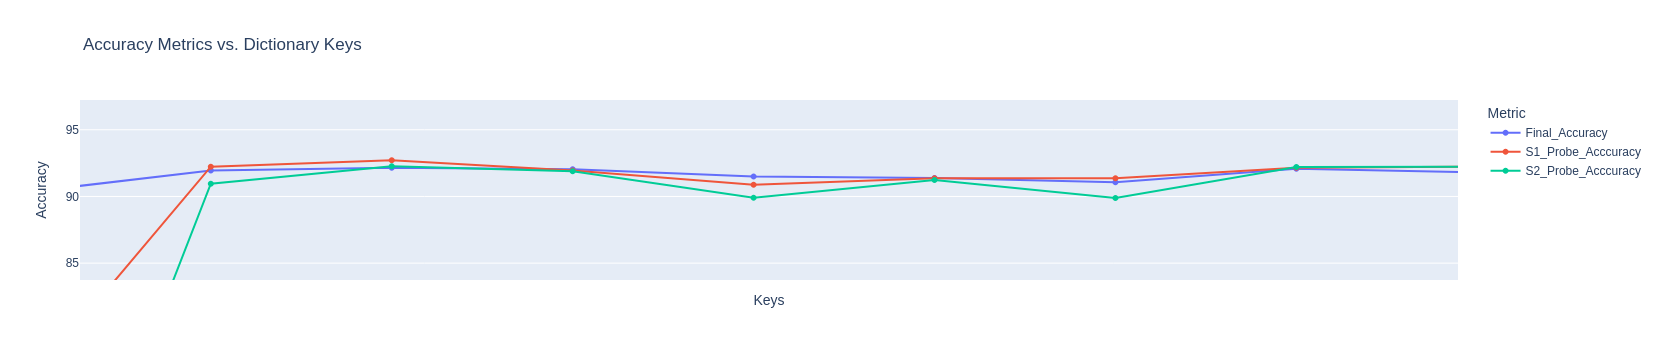

In [25]:
# Create line plot with plotly.express
fig = px.line(
    df_long,
    x='Key',
    y='Value',
    color='Metric',
    title='Accuracy Metrics vs. Dictionary Keys',
    labels={'Key': 'Keys', 'Value': 'Accuracy', 'Metric': 'Metric'},
    markers=True  # Add markers to the lines
)

# Update layout for better visualization
fig.update_layout(
    yaxis=dict(range=[min(df_long['Value']) - 5, max(100, max(df_long['Value']) + 5)]),
    xaxis=dict(tickmode='linear'),  # Adjust if keys are non-numerical
    showlegend=True
)

# Show the plot
fig.show()